# Part II: Implementing ResNet Architecture [20 points]

**STEPS:**


1. Implementnt residual blocks of ResNet, including convolutional layers, batch
normalization, ReLU activation, and residual connections. You can use nn.Conv2d,
nn.BatchNorm2d, nn.Sequential, nn.Identity.

2. Design a Resnet-18 model: configuration with 18-layer original ResNet paper.


3. Train the model on the dataset that you used in Part I. For your dataset, adjust the size, e.g. for the input and the output layers.

4. Apply at least two techniques to prevent overfitting and improve the results.

8. Save the weights of the trained neural network that provides the best results. Check
saving and loading models (PyTorch)

9. Discuss the results and provide relevant graphs:

• Report training accuracy, training loss, validation accuracy, validation loss,
testing accuracy, and testing loss.

• Plot the training and validation accuracy over time (epochs).

• Plot the training and validation loss over time (epochs).

• Generate a confusion matrix using the model's predictions on the test set.

• Calculate and report other evaluation metrics such as Precision, recall and F1
score (more details). You can use sklearn.metrics.precision_recall_fscore_support


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.graph_objs as go
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, mean_squared_error
import torch
import random
import numpy as np
import torchvision
import gc
import tqdm
from torchinfo import summary
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from torchmetrics.classification import MulticlassAccuracy, MulticlassROC, MulticlassConfusionMatrix
import matplotlib.pyplot as plt
import torch.optim as lr_scheduler
import torch.backends.cudnn as cudnn 
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import os
import gc
cudnn.benchmark = True
plt.ion() 
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics import MulticlassPrecisionRecallCurve
import torch.utils.data as data
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, recall_score,precision_score,f1_score,confusion_matrix,precision_recall_fscore_support

In [2]:

transform_data = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
dataset = ImageFolder('cnn_dataset', transform= transform_data)
dataset

Dataset ImageFolder
    Number of datapoints: 30000
    Root location: cnn_dataset
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
classes = dataset.classes
classes

['dogs', 'food', 'vehicles']

In [5]:
print(f"Total number of images: {len(dataset)}")
print(f"Number of classes: {len(classes)}")

Total number of images: 30000
Number of classes: 3


In [6]:
dataset[0],dataset[1],dataset[2]

((tensor([[[0.9490, 0.9922, 0.8941,  ..., 0.8392, 0.9961, 0.9804],
           [0.9804, 1.0000, 0.8902,  ..., 0.8431, 0.9882, 0.9882],
           [1.0000, 1.0000, 0.8980,  ..., 0.8471, 1.0000, 0.9922],
           ...,
           [0.4510, 0.4235, 0.4275,  ..., 0.5686, 0.5412, 0.5137],
           [0.4392, 0.4000, 0.4118,  ..., 0.5137, 0.5176, 0.5294],
           [0.4706, 0.4431, 0.4000,  ..., 0.5020, 0.5020, 0.4902]],
  
          [[1.0000, 0.9882, 0.8196,  ..., 0.8196, 0.9922, 0.9961],
           [0.9922, 0.9882, 0.8118,  ..., 0.8235, 0.9843, 0.9882],
           [0.9569, 0.9686, 0.7725,  ..., 0.8353, 0.9843, 0.9882],
           ...,
           [0.0706, 0.0353, 0.0235,  ..., 0.0863, 0.0588, 0.0353],
           [0.0824, 0.0353, 0.0314,  ..., 0.0471, 0.0392, 0.0510],
           [0.1020, 0.0667, 0.0078,  ..., 0.0510, 0.0471, 0.0353]],
  
          [[0.9725, 0.9725, 0.8275,  ..., 0.7961, 0.9843, 1.0000],
           [0.9647, 0.9804, 0.8157,  ..., 0.8078, 0.9765, 0.9882],
           [0.9451, 0.

Graphical Representation

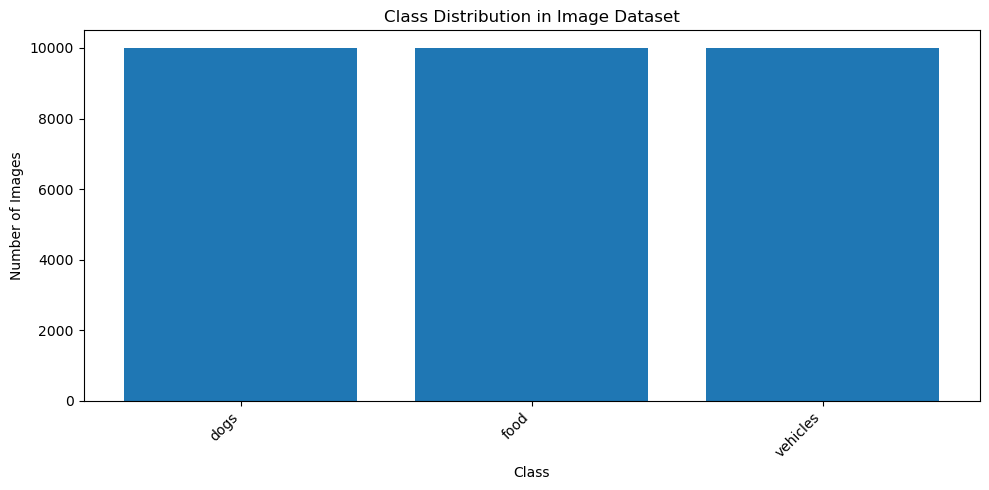

In [7]:
cnn_dir = "cnn_dataset"

class_labels = [label for label in os.listdir(cnn_dir) if not label.startswith('.')]
class_counts = {label: len(os.listdir(os.path.join(cnn_dir, label))) for label in class_labels}

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Image Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

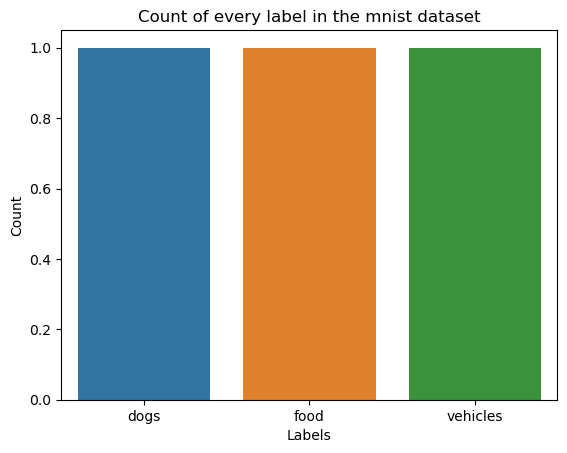

In [8]:
sns.countplot(class_labels)
plt.title('Count of every label in the mnist dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

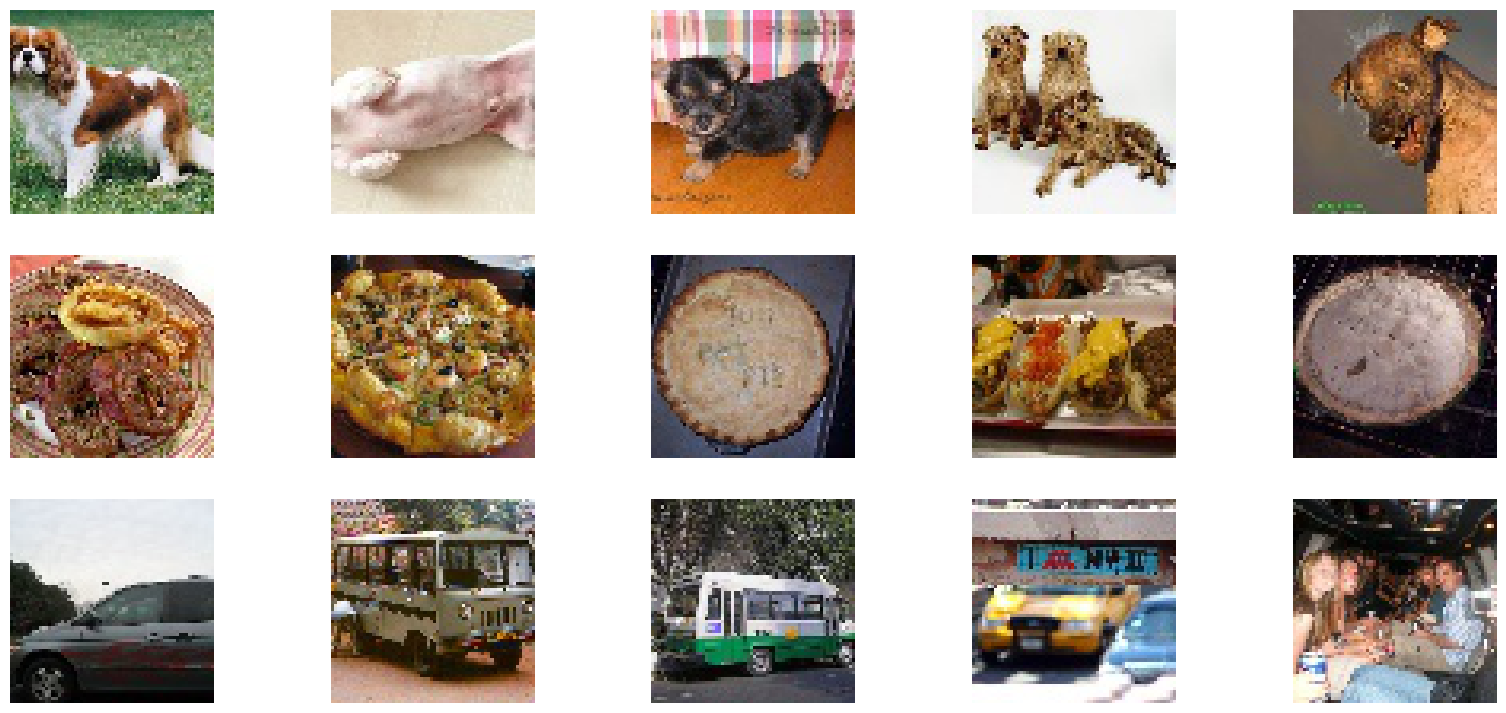

In [9]:
cnn_dir = "cnn_dataset"
image_files = os.listdir(cnn_dir)

num = 5

fig, axes = plt.subplots(len(class_labels), num, figsize=(20, 3 * len(class_labels)))


for j, label in enumerate(class_labels):
    class_dir = os.path.join(cnn_dir, label)
    image_files = [file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file))]
    for i in range(num):
        random_image_file = random.choice(image_files)
        image_path = os.path.join(class_dir, random_image_file)
        image = Image.open(image_path)
        axes[j, i].imshow(image)
        axes[j, i].axis('off')

plt.show()

preprocessing

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [10]:
batch_size = 128
lr = 0.0001
channels = 3

In [12]:
#without otpimization


In [11]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

size = len(dataset)
train_size = int(size*0.7)
val_size = int(0.5*(size-train_size))
test_size = int(size-(train_size+val_size))

print(size,train_size,val_size,test_size)

30000 21000 4500 4500


In [12]:
train_data,val_data,test_data = random_split(dataset,[train_size,val_size,test_size])

In [13]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_data, batch_size=batch_size,  shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size,  shuffle=False)

**ResNet Architecture**

In [16]:
class residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(residual_block, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                                   nn.BatchNorm2d(out_channels), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [17]:
class resnet_model_18(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(resnet_model_18, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias=False),nn.BatchNorm2d(64),nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self.make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self.make_layer(block, 128, layers[1], stride = 2) 
        self.layer2 = self.make_layer(block, 256, layers[2], stride = 2) 
        self.layer3 = self.make_layer(block, 512, layers[3], stride = 2) 
        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),nn.BatchNorm2d(planes))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
resnet_model_one = resnet_model_18(residual_block, [2,2,2,2],len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model_one.parameters(), lr, momentum = 0.9)  

In [18]:
resnet_model_one

resnet_model_18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): residual_block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): residual_block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-

In [19]:
summary(resnet_model_one,input=(batch_size,channels,64,64),device="cuda")

Layer (type:depth-idx)                   Param #
resnet_model_18                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
│    └─residual_block: 2-4               --
│    │    └─Sequential: 3-1              37,056
│    │    └─Sequential: 3-2              37,056
│    │    └─ReLU: 3-3                    --
│    └─residual_block: 2-5               --
│    │    └─Sequential: 3-4              37,056
│    │    └─Sequential: 3-5              37,056
│    │    └─ReLU: 3-6                    --
├─Sequential: 1-4                        --
│    └─residual_block: 2-6               --
│    │    └─Sequential: 3-7              74,112
│    │    └─Sequential: 3-8              147,840
│    │    └─Sequential: 3-9              8,576
│    │    └─ReLU: 3-10                 

In [20]:
train_losses_model_one = []
val_losses_model_one = []
train_accuracies_model_one = []
val_accuracies_model_one = []
test_losses_model_one=[]
test_accuracies_model_one=[]
model_one_true_labels = []
model_one_pred_labels = []

epochs=10
start_time=time.time()
for epoch in range(epochs):
    resnet_model_one.train()
    train_loss,correct,total  = 0.0,0,0
    for i, (images, labels) in enumerate(train_dataloader):  
        images,labels = images.to(device),labels.to(device)
        outputs = resnet_model_one(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        
    train_loss /= len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses_model_one.append(train_loss)
    train_accuracies_model_one.append(train_accuracy)  
    print(f"Epoch {epoch + 1},Train Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}%")

    resnet_model_one.eval()
    correct,total,val_loss = 0,0,0
    with torch.no_grad():
        correct,total = 0,0
        for images, labels in valid_dataloader:
            images, labels= images.to(device),labels.to(device)
            outputs = resnet_model_one(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
            val_loss += loss.item()

    val_loss /= len(valid_dataloader)
    val_accuracy = 100 * correct / total
    val_accuracies_model_one.append(val_accuracy)
    val_losses_model_one.append(val_loss)
    print(f"Validation Loss: {val_loss:.2f}, Accuracy: {val_accuracy:.2f}%")
    
    
    resnet_model_one.eval()
    correct,total,test_loss = 0,0,0

    with torch.no_grad():
        correct,total = 0,0
        for images, labels in test_dataloader:
            images, labels = images.to(device),labels.to(device)
            outputs = resnet_model_one(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.item()
            model_one_true_labels.extend(labels.cpu().numpy())
            model_one_pred_labels.extend(predicted.cpu().numpy())
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
            
    test_loss /= len(test_dataloader)
    test_accuracy = 100 * (correct / total)
    test_accuracies_model_one.append(test_accuracy)
    test_losses_model_one.append(test_loss)
    print(f"Test Loss: {test_loss:.2f}, Accuracy: {test_accuracy:.2f}%")
    
end_time=time.time()
print(f"The total time taken to execute the model is {end_time-start_time} ms.")

Epoch 1,Train Loss: 0.34712398052215576, Train Accuracy: 65.51428571428572%
Validation Loss: 0.34712398052215576, Accuracy: 76.13333333333334%
Test Loss: 0.34712398052215576, Accuracy: 75.91111111111111%
Epoch 2,Train Loss: 0.7896523475646973, Train Accuracy: 78.84761904761905%
Validation Loss: 0.7896523475646973, Accuracy: 80.71111111111111%
Test Loss: 0.7896523475646973, Accuracy: 81.2%
Epoch 3,Train Loss: 0.24054855108261108, Train Accuracy: 83.44285714285714%
Validation Loss: 0.24054855108261108, Accuracy: 82.88888888888889%
Test Loss: 0.24054855108261108, Accuracy: 83.6%
Epoch 4,Train Loss: 0.32594019174575806, Train Accuracy: 86.28571428571429%
Validation Loss: 0.32594019174575806, Accuracy: 84.17777777777778%
Test Loss: 0.32594019174575806, Accuracy: 85.06666666666666%
Epoch 5,Train Loss: 0.2142927497625351, Train Accuracy: 88.32380952380953%
Validation Loss: 0.2142927497625351, Accuracy: 85.28888888888889%
Test Loss: 0.2142927497625351, Accuracy: 85.8%
Epoch 6,Train Loss: 0.288

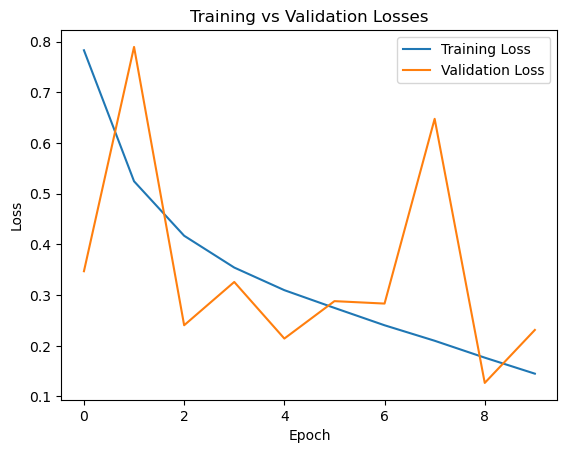

In [21]:
plt.plot(train_losses_model_one, label='Training Loss')
plt.plot(val_losses_model_one, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

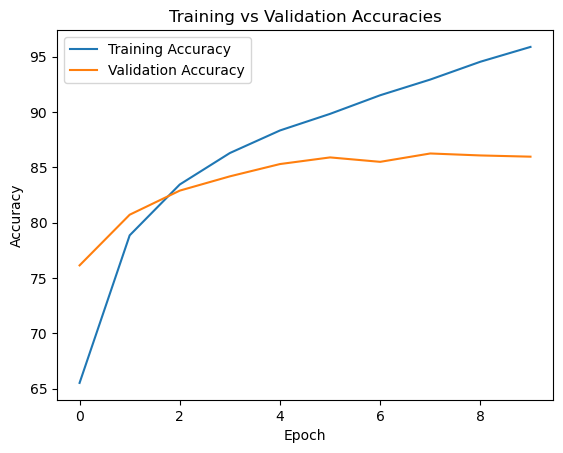

In [22]:
plt.plot(train_accuracies_model_one, label='Training Accuracy')
plt.plot(val_accuracies_model_one, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

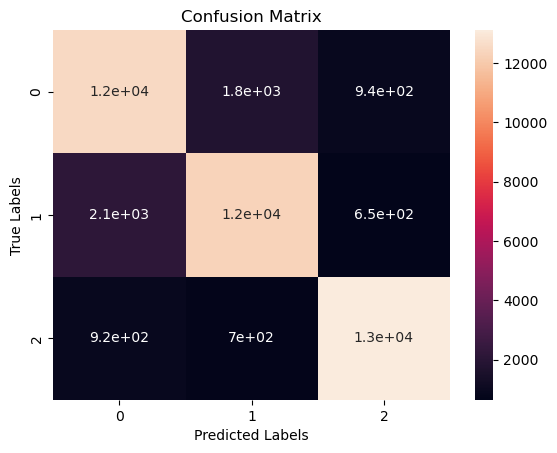

In [23]:
conf_matrix = confusion_matrix(model_one_true_labels, model_one_pred_labels)
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
precision = precision_score(model_one_true_labels, model_one_pred_labels, average = 'macro')
recall = recall_score(model_one_true_labels, model_one_pred_labels, average = 'macro')
f1 = f1_score(model_one_true_labels, model_one_pred_labels, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 0.84, Recall: 0.84, F1 Score: 0.84


# Model 2 - Hyperparameter tuning - Dropout

In [35]:
class residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(residual_block, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                                   nn.BatchNorm2d(out_channels), nn.ReLU(), nn.Dropout(0.1))
        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [36]:
class resnet_model_18(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(resnet_model_18, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias=False),nn.BatchNorm2d(64),nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self.make_layer(block, 64, layers[0], stride = 1) 
        self.layer1 = self.make_layer(block, 128, layers[1], stride = 2) 
        self.layer2 = self.make_layer(block, 256, layers[2], stride = 2) 
        self.layer3 = self.make_layer(block, 512, layers[3], stride = 2) 
        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),nn.BatchNorm2d(planes))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
resnet_model_two = resnet_model_18(residual_block, [2,2,2,2],len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model_two.parameters(), lr, momentum = 0.9)  

In [37]:
resnet_model_two

resnet_model_18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): residual_block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): residual_block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [39]:
summary(resnet_model_two,input=(batch_size,channels,64,64),device="cuda")

Layer (type:depth-idx)                   Param #
resnet_model_18                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
│    └─residual_block: 2-4               --
│    │    └─Sequential: 3-1              37,056
│    │    └─Sequential: 3-2              37,056
│    │    └─ReLU: 3-3                    --
│    └─residual_block: 2-5               --
│    │    └─Sequential: 3-4              37,056
│    │    └─Sequential: 3-5              37,056
│    │    └─ReLU: 3-6                    --
├─Sequential: 1-4                        --
│    └─residual_block: 2-6               --
│    │    └─Sequential: 3-7              74,112
│    │    └─Sequential: 3-8              147,840
│    │    └─Sequential: 3-9              8,576
│    │    └─ReLU: 3-10                 

In [40]:
train_losses_model_two = []
val_losses_model_two = []
train_accuracies_model_two = []
val_accuracies_model_two = []
test_losses_model_two=[]
test_accuracies_model_two=[]
model_two_true_labels = []
model_two_pred_labels = []

epochs=15
start_time=time.time()
for epoch in range(epochs):
    resnet_model_two.train()
    train_loss,correct,total  = 0.0,0,0
    for i, (images, labels) in enumerate(train_dataloader):  
        images,labels = images.to(device),labels.to(device)
        outputs = resnet_model_two(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        
    train_loss /= len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses_model_two.append(train_loss)
    train_accuracies_model_two.append(train_accuracy)  
    print(f"Epoch {epoch + 1},Train Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}%")

    resnet_model_two.eval()
    correct,total,val_loss = 0,0,0
    with torch.no_grad():
        correct,total = 0,0
        for images, labels in valid_dataloader:
            images, labels= images.to(device),labels.to(device)
            outputs = resnet_model_two(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
            val_loss += loss.item()

    val_loss /= len(valid_dataloader)
    val_accuracy = 100 * correct / total
    val_accuracies_model_two.append(val_accuracy)
    val_losses_model_two.append(val_loss)
    print(f"Validation Loss: {val_loss:.2f}, Accuracy: {val_accuracy:.2f}%")
    
    
    resnet_model_two.eval()
    correct,total,test_loss = 0,0,0

    with torch.no_grad():
        correct,total = 0,0
        for images, labels in test_dataloader:
            images, labels = images.to(device),labels.to(device)
            outputs = resnet_model_two(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.item()
            model_two_true_labels.extend(labels.cpu().numpy())
            model_two_pred_labels.extend(predicted.cpu().numpy())
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
            
    test_loss /= len(test_dataloader)
    test_accuracy = 100 * (correct / total)
    test_accuracies_model_two.append(test_accuracy)
    test_losses_model_two.append(test_loss)
    print(f"Test Loss: {test_loss:.2f}, Accuracy: {test_accuracy:.2f}%")
    
end_time=time.time()
print(f"The total time taken to execute the model is {end_time-start_time} ms.")

Epoch 1,Train Loss: 0.57, Train Accuracy: 60.00%
Validation Loss: 0.57, Accuracy: 69.98%
Test Loss: 0.57, Accuracy: 70.49%
Epoch 2,Train Loss: 0.88, Train Accuracy: 74.49%
Validation Loss: 0.88, Accuracy: 73.64%
Test Loss: 0.88, Accuracy: 73.93%
Epoch 3,Train Loss: 0.53, Train Accuracy: 78.76%
Validation Loss: 0.53, Accuracy: 78.11%
Test Loss: 0.53, Accuracy: 78.36%
Epoch 4,Train Loss: 0.10, Train Accuracy: 81.55%
Validation Loss: 0.10, Accuracy: 80.53%
Test Loss: 0.10, Accuracy: 80.82%
Epoch 5,Train Loss: 0.28, Train Accuracy: 83.43%
Validation Loss: 0.28, Accuracy: 73.60%
Test Loss: 0.28, Accuracy: 73.42%
Epoch 6,Train Loss: 0.11, Train Accuracy: 84.74%
Validation Loss: 0.11, Accuracy: 82.62%
Test Loss: 0.11, Accuracy: 83.04%
Epoch 7,Train Loss: 0.68, Train Accuracy: 85.92%
Validation Loss: 0.68, Accuracy: 83.24%
Test Loss: 0.68, Accuracy: 83.49%
Epoch 8,Train Loss: 1.05, Train Accuracy: 87.00%
Validation Loss: 1.05, Accuracy: 83.80%
Test Loss: 1.05, Accuracy: 84.44%
Epoch 9,Train Lo

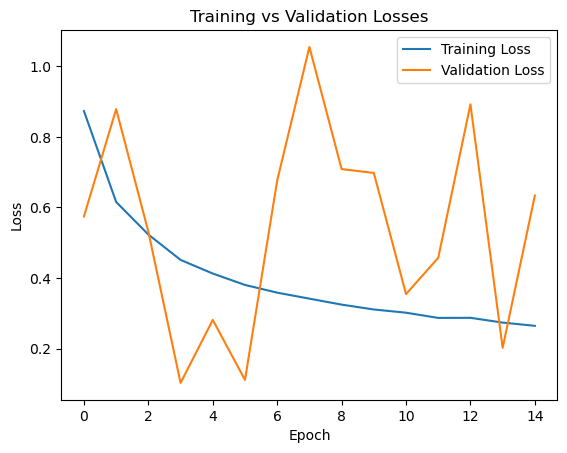

In [41]:
plt.plot(train_losses_model_two, label='Training Loss')
plt.plot(val_losses_model_two, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

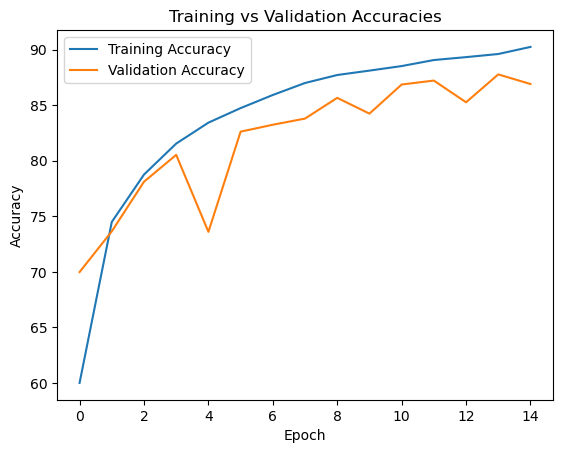

In [42]:
plt.plot(train_accuracies_model_two, label='Training Accuracy')
plt.plot(val_accuracies_model_two, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

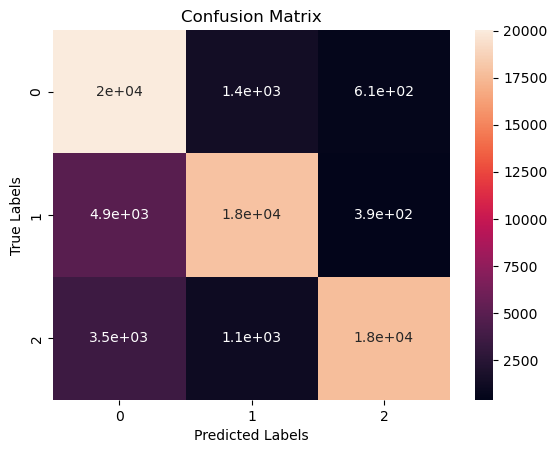

In [43]:
conf_matrix = confusion_matrix(model_two_true_labels, model_two_pred_labels)
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [44]:
precision = precision_score(model_two_true_labels, model_two_pred_labels, average = 'macro')
recall = recall_score(model_two_true_labels, model_two_pred_labels, average = 'macro')
f1 = f1_score(model_two_true_labels, model_two_pred_labels, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 0.84, Recall: 0.82, F1 Score: 0.83


# Model 3 - Hyperparameter tuning - Early Stopping

In [34]:
class residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(residual_block, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                                   nn.BatchNorm2d(out_channels), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [35]:
class resnet_model_18(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(resnet_model_18, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias=False),nn.BatchNorm2d(64),nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self.make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self.make_layer(block, 128, layers[1], stride = 2) 
        self.layer2 = self.make_layer(block, 256, layers[2], stride = 2) 
        self.layer3 = self.make_layer(block, 512, layers[3], stride = 2) 
        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),nn.BatchNorm2d(planes))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
resnet_model_three = resnet_model_18(residual_block, [2,2,2,2],len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model_three.parameters(), lr, momentum = 0.9)  

In [36]:
resnet_model_three

resnet_model_18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): residual_block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): residual_block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-

In [37]:
summary(resnet_model_three,input=(batch_size,channels,64,64),device="cuda")

Layer (type:depth-idx)                   Param #
resnet_model_18                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
│    └─residual_block: 2-4               --
│    │    └─Sequential: 3-1              37,056
│    │    └─Sequential: 3-2              37,056
│    │    └─ReLU: 3-3                    --
│    └─residual_block: 2-5               --
│    │    └─Sequential: 3-4              37,056
│    │    └─Sequential: 3-5              37,056
│    │    └─ReLU: 3-6                    --
├─Sequential: 1-4                        --
│    └─residual_block: 2-6               --
│    │    └─Sequential: 3-7              74,112
│    │    └─Sequential: 3-8              147,840
│    │    └─Sequential: 3-9              8,576
│    │    └─ReLU: 3-10                 

In [38]:
train_losses_model_three = []
val_losses_model_three = []
train_accuracies_model_three = []
val_accuracies_model_three = []
test_losses_model_three =[]
test_accuracies_model_three =[]
model_three_true_labels = []
model_three_pred_labels = []
patience = 2 
best_val_loss = np.Inf
counter = 0
max_stagnation = 5 
best_val_loss, best_val_epoch = None, None


epochs=20
start_time=time.time()
for epoch in range(epochs):
    resnet_model_three.train()
    train_loss,correct,total  = 0.0,0,0
    for i, (images, labels) in enumerate(train_dataloader):  
        images,labels = images.to(device),labels.to(device)
        outputs = resnet_model_three(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        
    train_loss /= len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses_model_three.append(train_loss)
    train_accuracies_model_three.append(train_accuracy)  
    print(f"Epoch {epoch + 1},Train Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}%")

    resnet_model_three.eval()
    correct,total,val_loss = 0,0,0
    with torch.no_grad():
        correct,total = 0,0
        for images, labels in valid_dataloader:
            images, labels= images.to(device),labels.to(device)
            outputs = resnet_model_three(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
            val_loss += loss.item()

    val_loss /= len(valid_dataloader)
    val_accuracy = 100 * correct / total
    val_accuracies_model_three.append(val_accuracy)
    val_losses_model_three.append(val_loss)
    print(f"Validation Loss: {val_loss:.2f}, Accuracy: {val_accuracy:.2f}%")
    if best_val_loss == None:
        best_val_loss = round(val_loss, 2)
    elif val_loss < best_val_loss:
        best_val_loss = round(val_loss, 2)
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping...")
        break

    
    resnet_model_three.eval()
    correct,total,test_loss = 0,0,0

    with torch.no_grad():
        correct,total = 0,0
        for images, labels in test_dataloader:
            images, labels = images.to(device),labels.to(device)
            outputs = resnet_model_three(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.item()
            model_three_true_labels.extend(labels.cpu().numpy())
            model_three_pred_labels.extend(predicted.cpu().numpy())
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
            
    test_loss /= len(test_dataloader)
    test_accuracy = 100 * (correct / total)
    test_accuracies_model_three.append(test_accuracy)
    test_losses_model_three.append(test_loss)
    print(f"Test Loss: {test_loss:.2f}, Accuracy: {test_accuracy:.2f}%")
    
end_time=time.time()
print(f"The total time taken to execute the model is {end_time-start_time} ms.")

Epoch 1,Train Loss: 0.49377942085266113, Train Accuracy: 65.4%
Validation Loss: 0.49377942085266113, Accuracy: 75.71111111111111%
Test Loss: 0.49377942085266113, Accuracy: 75.73333333333333%
Epoch 2,Train Loss: 0.41918253898620605, Train Accuracy: 79.10952380952381%
Validation Loss: 0.41918253898620605, Accuracy: 80.71111111111111%
Test Loss: 0.41918253898620605, Accuracy: 80.64444444444445%
Epoch 3,Train Loss: 0.19127076864242554, Train Accuracy: 83.86666666666666%
Validation Loss: 0.19127076864242554, Accuracy: 84.13333333333334%
Test Loss: 0.19127076864242554, Accuracy: 84.11111111111111%
Epoch 4,Train Loss: 0.4052892327308655, Train Accuracy: 87.1047619047619%
Validation Loss: 0.4052892327308655, Accuracy: 86.11111111111111%
Test Loss: 0.4052892327308655, Accuracy: 85.4888888888889%
Epoch 5,Train Loss: 0.10560552775859833, Train Accuracy: 89.01428571428572%
Validation Loss: 0.10560552775859833, Accuracy: 86.24444444444444%
Test Loss: 0.10560552775859833, Accuracy: 86.17777777777778

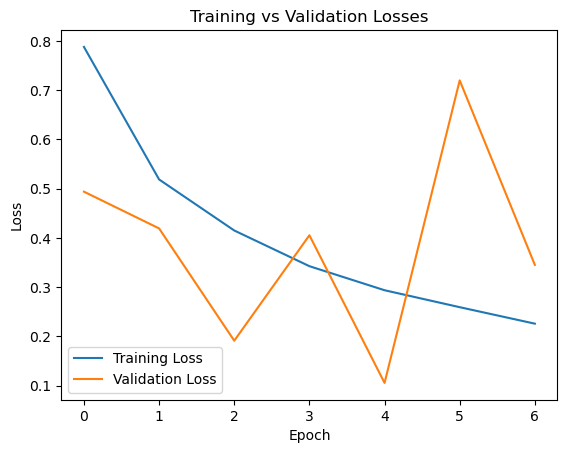

In [39]:
plt.plot(train_losses_model_three, label='Training Loss')
plt.plot(val_losses_model_three, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

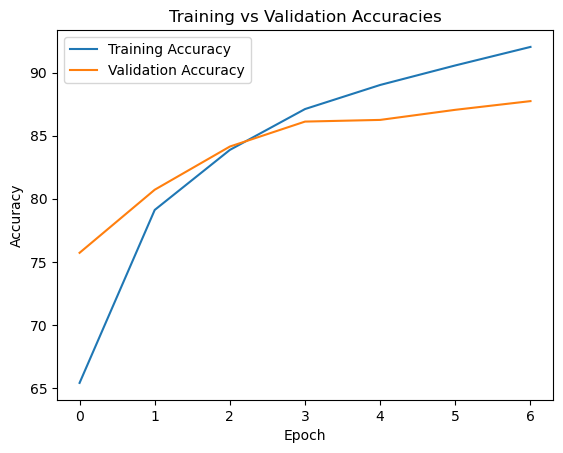

In [55]:
plt.plot(train_accuracies_model_three, label='Training Accuracy')
plt.plot(val_accuracies_model_three, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

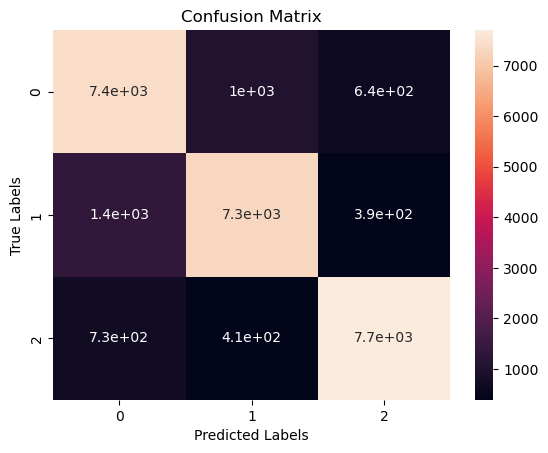

In [41]:
conf_matrix = confusion_matrix(model_three_true_labels, model_three_pred_labels)
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [42]:
precision = precision_score(model_three_true_labels, model_three_pred_labels, average = 'macro')
recall = recall_score(model_three_true_labels, model_three_pred_labels, average = 'macro')
f1 = f1_score(model_three_true_labels, model_three_pred_labels, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 0.83, Recall: 0.83, F1 Score: 0.83


In [43]:
torch.save(resnet_model_three.state_dict(), 'rsingh57_ts92_assignment1_part_2_best_model_early_stopping.h5')

# Model 4 - Hyperparameter tuning - Regularization L2 - 0.005

In [44]:
class residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(residual_block, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                                   nn.BatchNorm2d(out_channels), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [46]:
class resnet_model_18(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(resnet_model_18, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias=False),nn.BatchNorm2d(64),nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self.make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self.make_layer(block, 128, layers[1], stride = 2) 
        self.layer2 = self.make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self.make_layer(block, 512, layers[3], stride = 2) 
        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),nn.BatchNorm2d(planes))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
resnet_model_four = resnet_model_18(residual_block, [2,2,2,2],len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model_four.parameters(), lr, weight_decay = 0.005, momentum = 0.9)  

In [47]:
resnet_model_four

resnet_model_18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): residual_block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): residual_block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-

In [49]:
summary(resnet_model_four,input=(batch_size,channels,64,64),device="cuda")

Layer (type:depth-idx)                   Param #
resnet_model_18                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
│    └─residual_block: 2-4               --
│    │    └─Sequential: 3-1              37,056
│    │    └─Sequential: 3-2              37,056
│    │    └─ReLU: 3-3                    --
│    └─residual_block: 2-5               --
│    │    └─Sequential: 3-4              37,056
│    │    └─Sequential: 3-5              37,056
│    │    └─ReLU: 3-6                    --
├─Sequential: 1-4                        --
│    └─residual_block: 2-6               --
│    │    └─Sequential: 3-7              74,112
│    │    └─Sequential: 3-8              147,840
│    │    └─Sequential: 3-9              8,576
│    │    └─ReLU: 3-10                 

In [50]:
train_losses_model_four = []
val_losses_model_four = []
train_accuracies_model_four = []
val_accuracies_model_four = []
test_losses_model_four =[]
test_accuracies_model_four =[]
model_four_true_labels = []
model_four_pred_labels = []



epochs=10
start_time=time.time()
for epoch in range(epochs):
    resnet_model_four.train()
    train_loss,correct,total  = 0.0,0,0
    for i, (images, labels) in enumerate(train_dataloader):  
        images,labels = images.to(device),labels.to(device)
        outputs = resnet_model_four(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        
    train_loss /= len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses_model_four.append(train_loss)
    train_accuracies_model_four.append(train_accuracy)  
    print(f"Epoch {epoch + 1},Train Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}%")

    resnet_model_four.eval()
    correct,total,val_loss = 0,0,0
    with torch.no_grad():
        correct,total = 0,0
        for images, labels in valid_dataloader:
            images, labels= images.to(device),labels.to(device)
            outputs = resnet_model_four(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
            val_loss += loss.item()

    val_loss /= len(valid_dataloader)
    val_accuracy = 100 * correct / total
    val_accuracies_model_four.append(val_accuracy)
    val_losses_model_four.append(val_loss)
    print(f"Validation Loss: {val_loss:.2f}, Accuracy: {val_accuracy:.2f}%")
    
    
    resnet_model_four.eval()
    correct,total,test_loss = 0,0,0

    with torch.no_grad():
        correct,total = 0,0
        for images, labels in test_dataloader:
            images, labels = images.to(device),labels.to(device)
            outputs = resnet_model_four(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.item()
            model_four_true_labels.extend(labels.cpu().numpy())
            model_four_pred_labels.extend(predicted.cpu().numpy())
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
            
    test_loss /= len(test_dataloader)
    test_accuracy = 100 * (correct / total)
    test_accuracies_model_four.append(test_accuracy)
    test_losses_model_four.append(test_loss)
    print(f"Test Loss: {test_loss:.2f}, Accuracy: {test_accuracy:.2f}%")
    
end_time=time.time()
print(f"The total time taken to execute the model is {end_time-start_time} ms.")

Epoch 1,Train Loss: 0.86, Train Accuracy: 66.81%
Validation Loss: 0.86, Accuracy: 76.16%
Test Loss: 0.86, Accuracy: 76.69%
Epoch 2,Train Loss: 0.66, Train Accuracy: 79.47%
Validation Loss: 0.66, Accuracy: 80.33%
Test Loss: 0.66, Accuracy: 81.31%
Epoch 3,Train Loss: 0.40, Train Accuracy: 83.50%
Validation Loss: 0.40, Accuracy: 82.87%
Test Loss: 0.40, Accuracy: 83.47%
Epoch 4,Train Loss: 0.66, Train Accuracy: 85.68%
Validation Loss: 0.66, Accuracy: 83.93%
Test Loss: 0.66, Accuracy: 85.31%
Epoch 5,Train Loss: 0.94, Train Accuracy: 87.60%
Validation Loss: 0.94, Accuracy: 85.02%
Test Loss: 0.94, Accuracy: 85.56%
Epoch 6,Train Loss: 0.10, Train Accuracy: 89.41%
Validation Loss: 0.10, Accuracy: 85.44%
Test Loss: 0.10, Accuracy: 86.09%
Epoch 7,Train Loss: 0.94, Train Accuracy: 91.06%
Validation Loss: 0.94, Accuracy: 85.76%
Test Loss: 0.94, Accuracy: 86.22%
Epoch 8,Train Loss: 1.48, Train Accuracy: 92.66%
Validation Loss: 1.48, Accuracy: 86.11%
Test Loss: 1.48, Accuracy: 86.56%
Epoch 9,Train Lo

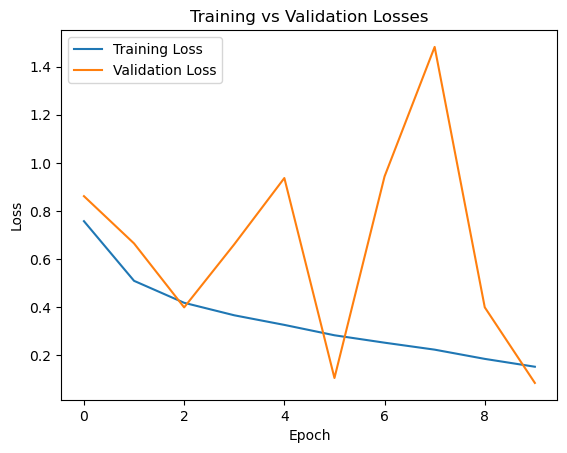

In [51]:
plt.plot(train_losses_model_four, label='Training Loss')
plt.plot(val_losses_model_four, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

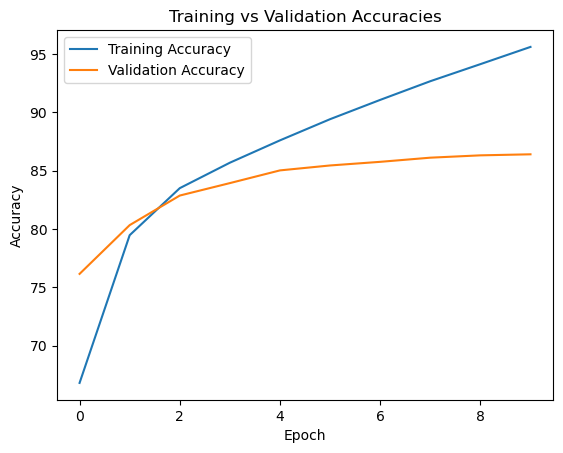

In [52]:
plt.plot(train_accuracies_model_four, label='Training Accuracy')
plt.plot(val_accuracies_model_four, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

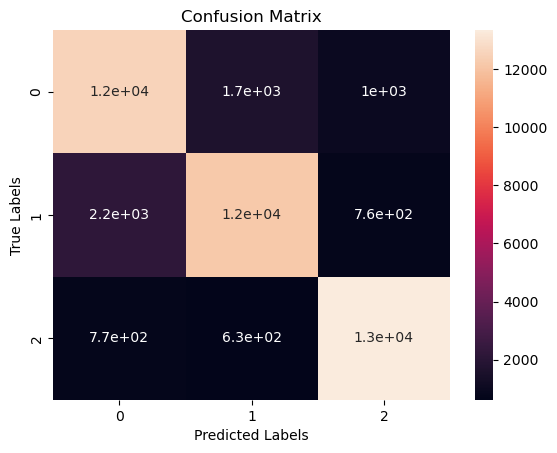

In [53]:
conf_matrix = confusion_matrix(model_four_true_labels, model_four_pred_labels)
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [54]:
precision = precision_score(model_four_true_labels, model_four_pred_labels, average = 'macro')
recall = recall_score(model_four_true_labels, model_four_pred_labels, average = 'macro')
f1 = f1_score(model_four_true_labels, model_four_pred_labels, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 0.84, Recall: 0.84, F1 Score: 0.84


# References


- Part 3 is based on the CSE 574 Machine Learning Assignment 0,1,2,3 and Quiz 5submission by Radhika Singh[rsingh57, 50537855] and CSE 676 Deep Learning Assignment 0 - Part1,3  Submission by Radhika Singh[rsingh57@buffalo.edu, 50537855]
- https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/
- https://medium.com/@karuneshu21/how-to-resnet-in-pytorch-9acb01f36cf5
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
- https://pytorch.org/tutorials/beginner/saving_loading_models.html
- https://arxiv.org/pdf/1512.03385.pdf
- https://thedatafrog.com/en/articles/visualizing-datasets/![image.png](attachment:image.png)
